In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.stats import t
import sys
import scipy.io
from bisect import bisect
import copy

In [6]:
# Cutting the MH Budget Method: Korattikara's paper
class cut_mh:
    def __init__(self,x):
        self.X = x
        self.N = x.shape[0]
        
    def randomWalkProposer(self, theta, eps_sq):
        # random walk proposer to get the next parameter set
        # input: theta: 1-D Array like, of length 2
        #        eps_sq: 2-D Array like, the covariance matrix
        noise = np.random.multivariate_normal(np.array([0,0]), eps_sq).reshape((2,1))
        return theta + noise
    
    def log_f_prior(self, theta, theta_var):
        '''
        function to calculate the prior term : log(p(\theta))
        '''
        Sigma = np.array([[theta_var[0],0],[0,theta_var[1]]])
        res_first_part = -1.0 * np.log( 2 * np.pi * np.sqrt(np.linalg.det(Sigma)) ) 
        res_second_part = -0.5 * (theta.T).dot(np.linalg.inv(Sigma)).dot(theta)
        return res_first_part + res_second_part
    
    def compute_mu0(self, theta_c, theta_p, theta_var, N):
        prior_old = self.log_f_prior(theta_c, theta_var)
        prior_new = self.log_f_prior(theta_p, theta_var)
        log_u = np.log(np.random.random())
        
        assert not np.isnan(prior_old)
        assert not np.isnan(prior_new)
        assert not np.isnan(log_u)
        
        res = 1.0 /N * ( log_u + prior_old - prior_new )
        assert not np.isnan(res)
        
        return res
    
    def mh_test(self, theta_c, theta_p, mb_size, X, N, mu_0, eps_tolerance, T, var_X):
        '''
        performing MH test: theta_c: current paramter value
                            theta_p: potential new parameter value
                            mb_size: minibatch size
                            X      : total data set
                            N      : size of total data set
                            T      : temperature
                            var_X  : the variance of X
        '''
        accept = False
        done = False
        n = 0
        
        index = np.random.permutation(N)
        X = X[index]
        
        while not done:
            size = np.min([mb_size, N-n])  # minibatch size
            n = n + size
            X_mini = (X[:n]).reshape((n,1))
            
            # compute l_bar, l_bar_square
            numerator = np.exp(-0.5/var_X * (X_mini - theta_p[0])**2 ) \
                      + np.exp(-0.5/var_X * (X_mini- (theta_p[0] + theta_p[1])) **2 )
            denominator = np.exp(-0.5/var_X * (X_mini - theta_c[0])**2 )\
                      + np.exp(-0.5/var_X * (X_mini - (theta_c[0] + theta_c[1])) ** 2)
            log_terms = (1.0/T) * np.log(numerator/denominator)
            l_bar = (1.0/n) * np.sum(log_terms)
            l_bar_square = (1.0/n) * np.sum(log_terms**2)
            
            assert not np.isnan(np.sum(numerator))
            assert not np.isnan(np.sum(denominator))
            assert not np.isnan(l_bar)
            assert not np.isnan(l_bar_square)
            
            if (n == N):
                delta = 0
            else:
                s_l = np.sqrt( (l_bar_square - (l_bar**2)) * (float(n)/(n-1)) )
                s = (s_l/ np.sqrt(n)) * np.sqrt( 1 - (float(n-1)/(N-1))  )
                test_statistic = np.abs( (l_bar - mu_0)/s )
                delta = 1 - t.cdf(test_statistic, n-1)
                assert not np.isnan(delta)
                assert not np.isnan(s)
                
            if (delta < eps_tolerance) :
                if ( l_bar > mu_0 ):
                    accept = True
                done = True
        return (accept, n)
            
    def posterior_estimate(self, num_pass, rw_eps, temperature, mb_size, theta_start, tolerance, var_X, theta_var):
        theta = theta_start
        theta_list = theta_start
        X = self.X
        cutting_MH_sizes_accept = []
        cutting_MH_sizes_reject = []
        cutting_MH_accept = []
        cutting_MH_reject = []
        data_consume = []
        for T in range(1, num_pass):
            theta_new = self.randomWalkProposer(theta, rw_eps)
            mu_0 = self.compute_mu0(theta, theta_new, theta_var, self.N)
            (accept, this_mb_size) = self.mh_test(theta, theta_new, mb_size, X, self.N, mu_0, tolerance, temperature, var_X)
            
            assert this_mb_size >= mb_size
            
            if accept:
                theta = theta_new
                cutting_MH_sizes_accept.append(this_mb_size)
                cutting_MH_accept.append(T)
            else:
                cutting_MH_sizes_reject.append(this_mb_size)
                cutting_MH_reject.append(T)
            theta_list = np.concatenate( (theta_list, theta), axis=1 )
            data_consume.append(this_mb_size)
        return (theta_list, data_consume) 

In [7]:
# Generate data
N = 10000 # number of points
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1
X = np.zeros(N)
i = 0
while i < N :
    u = np.random.random()
    if (u<0.5):
        X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
        i = i + 1
    else :
        X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))
        i = i + 1

Temperature and minibatch size are:
1 50


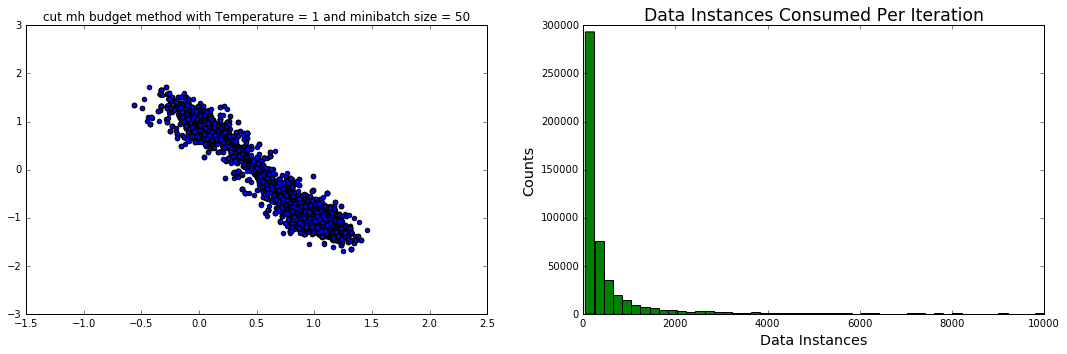

Temperature and minibatch size are:
1 100


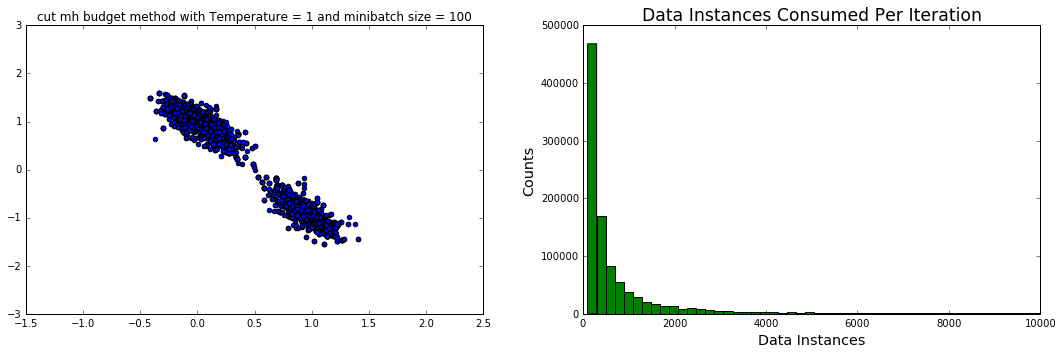

Temperature and minibatch size are:
1 200


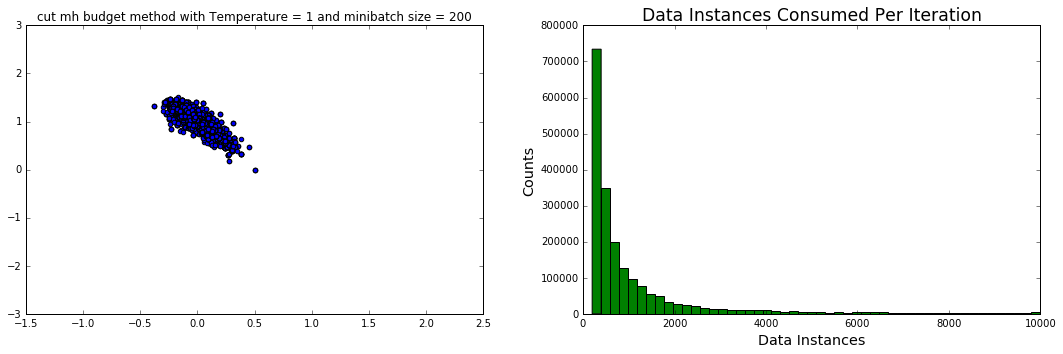

Temperature and minibatch size are:
2 50


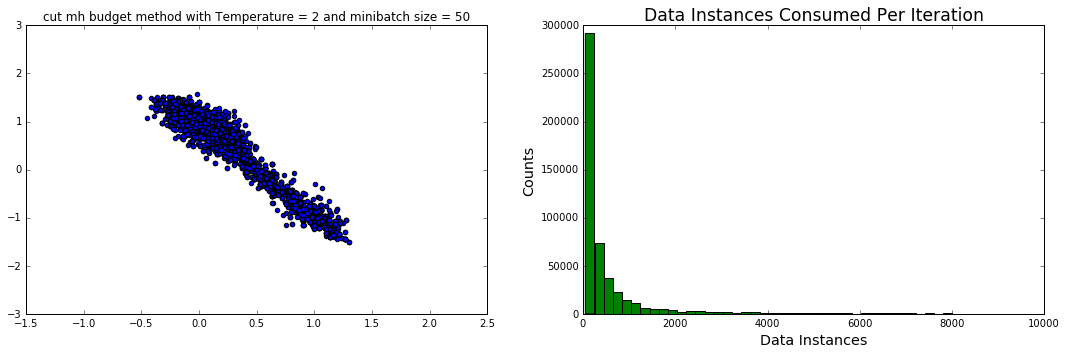

Temperature and minibatch size are:
2 100


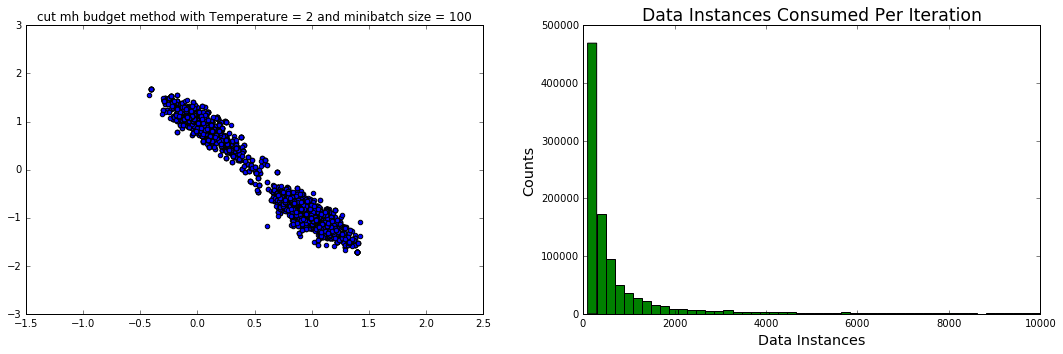

Temperature and minibatch size are:
2 200


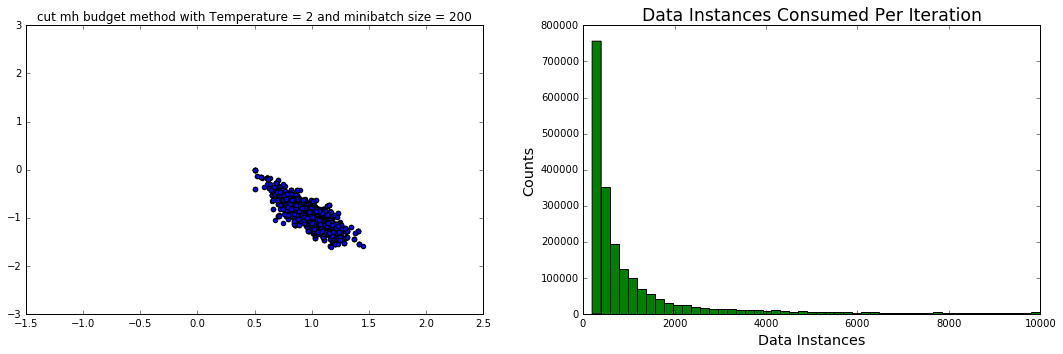

Temperature and minibatch size are:
50 50


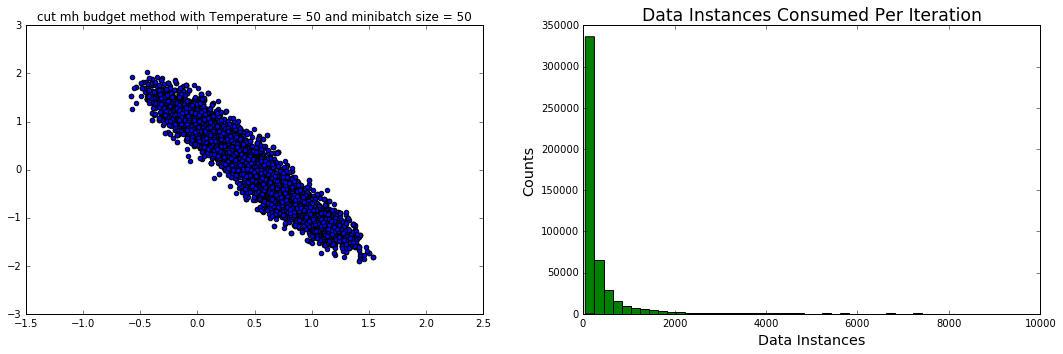

Temperature and minibatch size are:
50 100


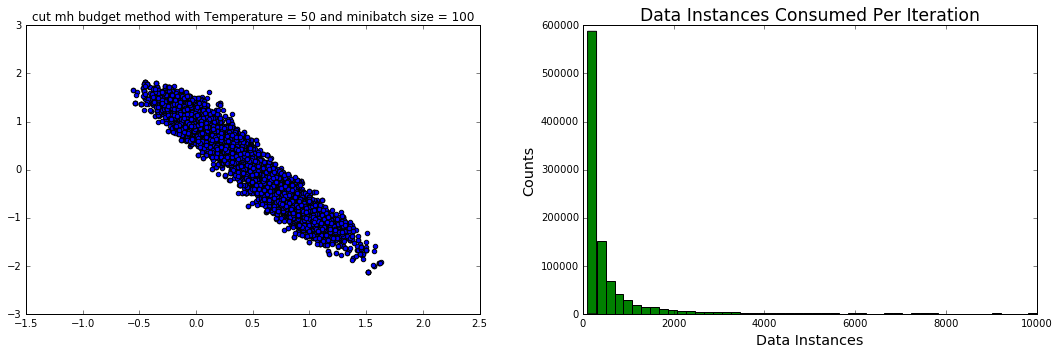

Temperature and minibatch size are:
50 200


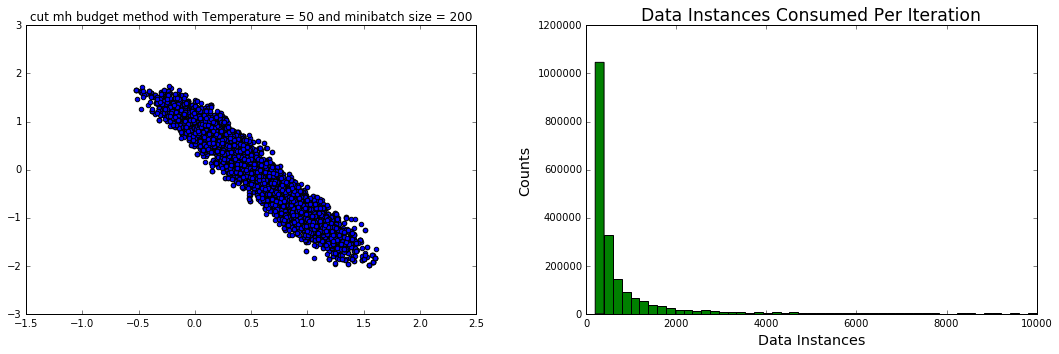

Temperature and minibatch size are:
500 50


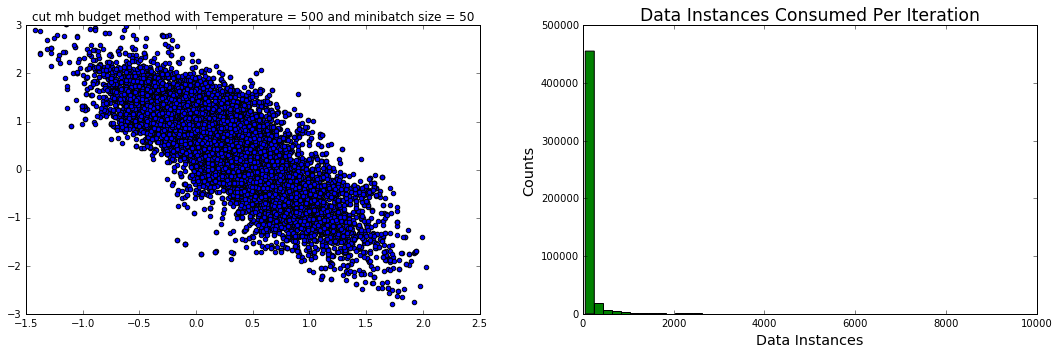

Temperature and minibatch size are:
500 100


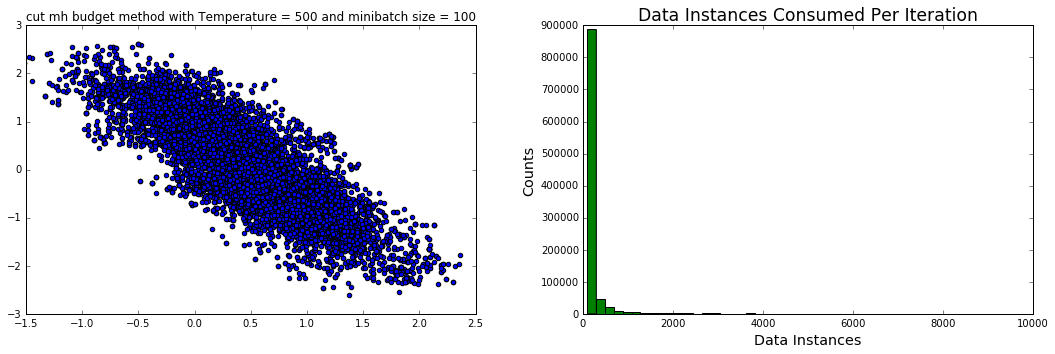

Temperature and minibatch size are:
500 200


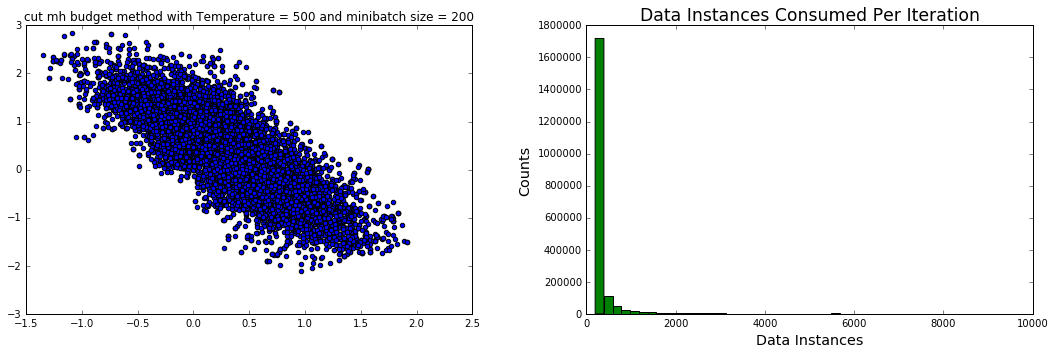

Temperature and minibatch size are:
5000 50


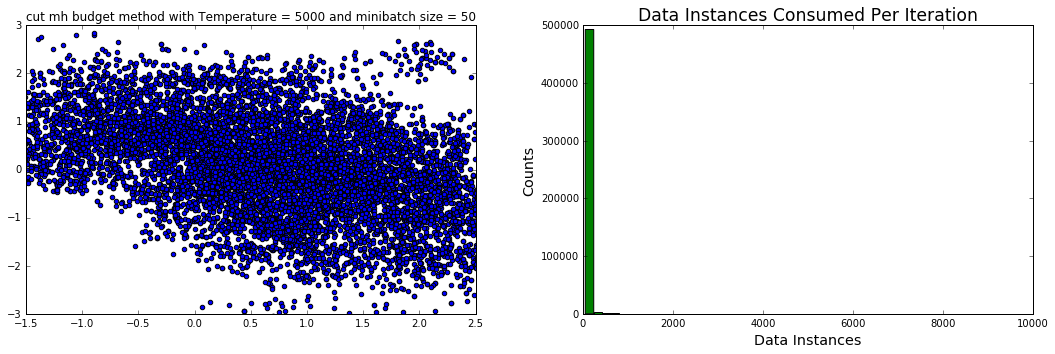

Temperature and minibatch size are:
5000 100


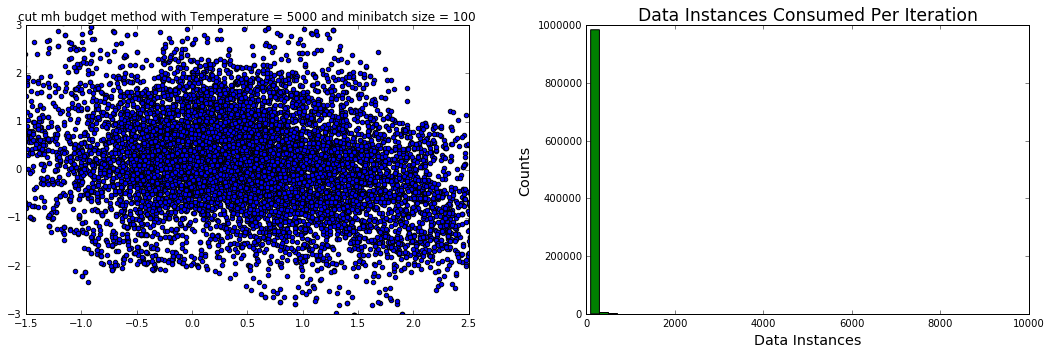

Temperature and minibatch size are:
5000 200


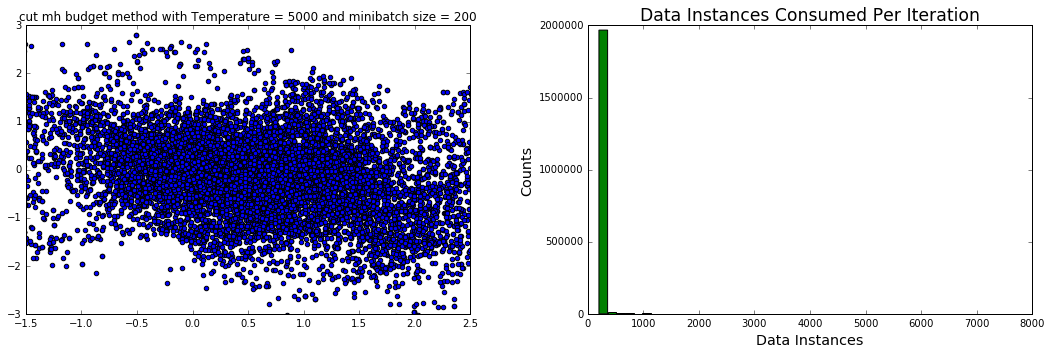

In [8]:
# run the adaptive sampling method
num_passes = 10000
rw_eps = 0.03 * np.eye(2)
temperature = 110
mb_size = 200
theta = np.array([[0.5],[0]])
mhtest = cut_mh(X)
tolerance = 0.1
var_X = 2
theta_var = np.array([10,1])

for temperature in [1,2,50,500,5000]:
    for mb_size in [50,100,200]:
        print 'Temperature and minibatch size are:' 
        print temperature, mb_size
        (all3, data_consume) = mhtest.posterior_estimate(num_passes,rw_eps,temperature,mb_size,theta, tolerance, \
                             var_X, theta_var)
        # plot result
        fig, axarr = plt.subplots(1,2,figsize=(15,5))
        axarr[0].set_title("cut mh budget method with Temperature = " + str(temperature) + \
                           " and minibatch size = " + str(mb_size) )
        axarr[0].scatter(all3[0], all3[1])
        axarr[0].set_xlim([-1.5,2.5])
        axarr[0].set_ylim([-3,3])
        dataconsume = np.asarray(data_consume)
        axarr[1].set_title("Data Instances Consumed Per Iteration", size="xx-large")
        axarr[1].hist(data_consume*mb_size, bins=50, facecolor ='green')
        axarr[1].set_xlabel("Data Instances", size="x-large")
        axarr[1].set_ylabel("Counts", size="x-large")
        plt.tight_layout()
        plt.show()